In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_deepseek import ChatDeepSeek
# llm = ChatAnthropic(model="claude-3-5-haiku-latest")
llm = ChatOpenAI(model="gpt-4o-mini")
# llm = ChatDeepSeek(model="deepseek-chat")

#### Part 1: Build a Basic Chatbot

In [17]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}
                         
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

# Next, add an entry point. 
# This tells our graph where to start its work each time we run it.
graph_builder.add_edge(START, "chatbot")

# Similarly, set a finish point. 
# This instructs the graph "any time this node is run, you can exit."
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

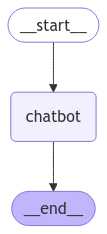

In [18]:
# visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
# Now let's run the chatbot!
def stream_graph_updates(user_input: str):
    # 注意：这里传入的 input，可以视为 State 的初始值
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: As of my last knowledge update in October 2023, LangGraph is a concept or tool that relates to the integration of language models with graph-based representations. This could involve using graphs to represent relationships in text, such as entities and their connections, allowing for more structured and relational approaches to natural language processing (NLP) tasks.

Graph-based representations can enhance the capabilities of language models by allowing them to leverage the topology and properties of the graph, providing more contextual understanding and the ability to reason over relationships and data points. In practice, frameworks like LangGraph might be applied in various applications including knowledge graphs, semantic search, or dialogue systems.

However, if LangGraph refers to a specific software, tool, or library that gained attention or was developed after my last update, I might not have the latest details on it. For the most current information, I recommend c

#### Part 2: 🛠️ Enhancing the Chatbot with Tools

接下来增强 bot 能力，集成进来一个 web search tool。

使用 Tavily，它提供了一个图，看着挺好，可以参考（Empower your chatbots to deliver precise, up-to-date responses by accessing a wide range of information through Tavily’s robust search capabilities.）

![Tavily Graph Example](https://tavily.com/_next/static/media/app-red-lg.25f93dc4.svg "Tavily Graph Example")

先来看下这个 tool：

In [21]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")


[{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sharing insights for AI community growth Follow"},
 {'url': 'https://langchain-ai.g

接下来看一个使用 tool 的例子：

In [22]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [23]:
import json
from langchain_core.messages import ToolMessage

# 手动实现一个 tool node，接收 state 作为输入
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools:list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict) -> dict:
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),  # json.dumps 将 Python 对象转换为 JSON 字符串格式
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
    
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [24]:
def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """

    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot", 
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
# Because the condition can return END, we don't need to explicitly set a finish_point this time. Our graph already has a way to finish!

graph = graph_builder.compile()

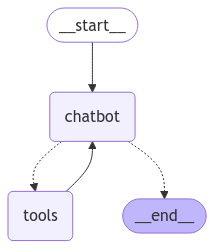

In [25]:
# visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://github.com/langchain-ai/langgraph", "content": "GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Let's build a tool-calling ReAct-style agent that uses a search tool! The simplest way to create a tool-calling agent in LangGraph is to use create_react_agent: Define the tools for the agent to use Define the tools for the agent to use This means that after tools is called, agent node is called next. workflow.add_edge(\"tools\", 'agent') Normal edge: after the tools are invoked, the graph should always return to the agent to decide what to do next LangGraph adds the input message to the internal state, then passes the state to the entrypoint node, \"agent\"."}, {"url": "https://www.langchain.com/langgraph", "content": "Build and scale agentic applications with LangGraph Platform. Design agent-dr

这一节代码的完整示例，使用 `ToolNode` 替换 `BasicToolNode`，使用 `tools_condition` 替换 `route_tools`：

In [28]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

#### Part 3: Adding Memory to the Chatbot

主要是通过 checkpointing 实现：

LangGraph solves this problem through persistent checkpointing. If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off.

In [29]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [31]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)

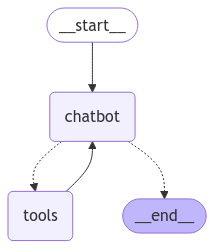

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [33]:
# First, pick a thread to use as the key for this conversation.
config = {"configurable": {"thread_id": "1"}}

In [34]:
user_input = "Hi there! My name is Tian Zhiwei."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Tian Zhiwei.
================================== Ai Message ==================================

Hello Tian Zhiwei! How can I assist you today?


In [35]:
user_input = "Remember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Tian Zhiwei! If there's anything specific you'd like to discuss or ask, feel free to let me know.


内存记忆必须是运行在同一个进程中才可以。试验了下，即使使用同一个 thread_id，在命令行两次执行 `python test.py` 就无法实现记忆能力。

In [36]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have access to personal data about users, including names, unless it has been shared in our conversation. How can I assist you today?


查看 state：

In [37]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Tian Zhiwei.', additional_kwargs={}, response_metadata={}, id='0c849d46-2a02-4780-a606-19d4e9cb5aa2'), AIMessage(content='Hello Tian Zhiwei! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 90, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-72f1520b-2366-46d8-9c82-889caec48d83-0', usage_metadata={'input_tokens': 90, 'output_tokens': 15, 'total_tokens': 105, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Remember my name?', addi

In [38]:
snapshot.next

()

这节代码的完整示例：

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

#### Part 4: Human-in-the-loop


通过 [interrupt](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#interrupt) 和 [Command](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#the-command-primitive) 实现：

In [43]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

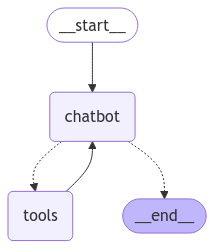

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [44]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_FA2Oe8LoaSVDXYHl5rXtjQIT)
 Call ID: call_FA2Oe8LoaSVDXYHl5rXtjQIT
  Args:
    query: I'm looking for expert guidance on building an AI agent. Can someone assist with the best practices, tools, and methodologies to get started?


大模型确实给出了 “human_assistance” 这个 tool 的调用，但是在执行 tool 时，被中断了，这个貌似是预期内的？但是没有出现需要人工介入的地方，human_response 也没有返回值，从 langSmith 上看是有报错的：GraphInterrupt。

In [45]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [46]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_FA2Oe8LoaSVDXYHl5rXtjQIT)
 Call ID: call_FA2Oe8LoaSVDXYHl5rXtjQIT
  Args:
    query: I'm looking for expert guidance on building an AI agent. Can someone assist with the best practices, tools, and methodologies to get started?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

For building an AI agent, it's recommended to explore **LangGraph**, which is noted for being reliable and extensible compared to simpler autonomous agents. If you need more specific guidance or resources on getting started, feel free to ask!


完整的代码示例：

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

#### Part 5: Customizing State

In [47]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [48]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt

@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt({
        "question": "Is this correct?",
        "name": name,
        "birthday": birthday,
    })
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"
    
    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [49]:
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [50]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_KD4uHjmWXu1IKPgffBY8dbXb)
 Call ID: call_KD4uHjmWXu1IKPgffBY8dbXb
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph/releases", "content": "Releases · langchain-ai/langgraph · GitHub Search code, repositories, users, issues, pull requests... Releases: langchain-ai/langgraph Releases · langchain-ai/langgraph langgraph: release 0.2.70 (#3341) langgraph: add agent name to AI messages in create_react_agent (#3340) fix(langgraph): Dedupe input (right-side) messages in add_messages (#3338) Merge branch 'jacob/dedupe' of

In [51]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_mssAYZabOFmCfSkomGJpIswy)
 Call ID: call_mssAYZabOFmCfSkomGJpIswy
  Args:
    name: LangGraph
    birthday: 2025-02-06
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

LangGraph was released on January 17, 2024.


In [52]:
snapshot = graph.get_state(config)
{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

langGraph 提到：在任何节点包括 interrupted 时，都可以修改 state

In [53]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1effcf25-a77a-6200-8006-1139bd4fd940'}}

In [54]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

完整的代码如下：

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str


@tool
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    return Command(update=state_update)


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

#### Part 6: Time Travel

能够回撤到之前的某个节点，重新对话

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [4]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_cnoCDZEAw7zeszeepJDUocmh)
 Call ID: call_cnoCDZEAw7zeszeepJDUocmh
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph", "content": "GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Let's build a tool-calling ReAct-style agent that uses a search tool! The simplest way to create a tool-calling agent in LangGraph is to use create_react_agent: Define the tools for the agent to use Define the tools for the agent to use This m

In [5]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

Building an autonomous agent with LangGraph sounds like an exciting project! With its capabilities for creating resilient and scalable agent-based applications, you can develop a wide range of features, from conversational interfaces to more complex task automation. If you have any specific ideas or need guidance on certain aspects of the development process, feel free to ask. Good luck with your project!


查看历史：

In [10]:
history = graph.get_state_history(config)
last_state = next(history)
print(last_state)

StateSnapshot(values={'messages': [HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='39e679cc-7484-40e6-8436-4f1dd5e221c4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_cnoCDZEAw7zeszeepJDUocmh', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 94, 'total_tokens': 114, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ad1c839f-7857-4535-a83c-642cf83f7b16-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGr

In [6]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state 
        # based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [86]:
print(to_replay.next)
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': UUID('676a9a98-1ced-46fd-a216-5594f5ac7d6f'), 'checkpoint_ns': '', 'checkpoint_id': '1efe9fce-7de4-674c-8007-ecaf17df8fb3'}}


to_replay 表示了要重新执行的 node，从上面的结果可以看出，这个 node 是 chatbot，表示重新获取 llm 的 response。

那 graph 回撤到哪个状态是依据什么呢：to_replay.config.checkpoint_id。

> Providing this checkpoint_id value tells LangGraph's checkpointer to load the state from that moment in time. 

In [11]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Building an autonomous agent with LangGraph sounds like an exciting project! With its capabilities for creating resilient and scalable agent-based applications, you can develop a wide range of features, from conversational interfaces to more complex task automation. If you have any specific ideas or need guidance on certain aspects of the development process, feel free to ask. Good luck with your project!
